![Atmospheric Toolbox](https://atmospherictoolbox.org/media/filer_public_thumbnails/filer_public/6d/35/6d35dffd-43f1-43ec-bff6-5aa066c8aabc/toolbox-header.jpg__1080x416_q85_subsampling-2.jpg)

# Atmospheric Toolbox - HARP regridding

This practical will show you how to read and visualize data from Earth Observation data products by making use of the [ESA Atmospheric Toolbox](https://atmospherictoolbox.org/).
The toolbox consists of four components which are CODA, HARP, VISAN, and QDOAS. In this exercise we will be focusing primarily on HARP.

A common way to demonstrate the HARP functionality is with the VISAN application that is part of the Atmospheric Toolbox. However, this application can only be run locally on a Desktop.
For this reason, we have chosen this time to demonstrate how to use the HARP functionality within a Jupyter Notebook. This can be run remotely on a server and accessed via a web browser. However, you can also still run this locally as well, if needed.

For the visualisations we will therefore make use of the matplotlib and cartopy libraries. Although there are both advantages and disadvantages of using matplotlib compared to the visualisations that VISAN provides, we will not go into detail on this in this exercise.

In the steps below we will provide a basic data reading and visualization introduction and then demonstrate the creation of a daily L3 grid file from one day of Sentinel-5P L2 NO2 products.

## Basic data reading with HARP

We first import the needed Python packages. This consists of NumPy, matplotlib, cartopy, and, of course, harp.

In [1]:
import harp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import Normalize
import cartopy.crs as ccrs

We will start by opening a single Sentinel-5P L2 NO2 product.
This product was retrieved from the [Sentinel-5P Pre-Operations Data Hub](https://s5phub.copernicus.eu/dhus/#/home).

In [2]:
filename = "../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc"
product = harp.import_product(filename)

The resulting `product` python variable is just a record containing the product variables with numpy arrays for the data. You can inspect the contents using the Python `print()` function:

In [3]:
print(product)

source product = 'S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc'

int scan_subindex {time=1877400}
double datetime_start {time=1877400} [seconds since 2010-01-01]
float datetime_length [s]
int orbit_index
long validity {time=1877400}
float latitude {time=1877400} [degree_north]
float longitude {time=1877400} [degree_east]
float latitude_bounds {time=1877400, 4} [degree_north]
float longitude_bounds {time=1877400, 4} [degree_east]
float sensor_latitude {time=1877400} [degree_north]
float sensor_longitude {time=1877400} [degree_east]
float sensor_altitude {time=1877400} [m]
float solar_zenith_angle {time=1877400} [degree]
float solar_azimuth_angle {time=1877400} [degree]
float sensor_zenith_angle {time=1877400} [degree]
float sensor_azimuth_angle {time=1877400} [degree]
double pressure_bounds {time=1877400, vertical=34, 2} [Pa]
float tropospheric_NO2_column_number_density {time=1877400} [mol/m^2]
float tropospheric_NO2_column_number_density_uncert

In [4]:
print(product.tropospheric_NO2_column_number_density)

type = float
dimension = {time=1877400}
unit = 'mol/m^2'
valid_min = -inf
valid_max = inf
description = 'tropospheric vertical column of NO2'
data =
[nan nan nan ... nan nan nan]



In [5]:
print(type(product.tropospheric_NO2_column_number_density.data))
print(product.tropospheric_NO2_column_number_density.data.shape)

<class 'numpy.ndarray'>
(1877400,)


It is important to realise that the `harp.import_product` function does not return the data in the same structure as it can be found in the netcdf file (and how you might get it with libraries such as `netCDF4` or `xarray`). HARP really performs an _import_ and converts the data from the original Sentinel-5P L2 format to a structure that is compatible with the HARP conventions.

This conversion mainly consists of renaming of variables, restructuring the dimensions, and leaving out the 'less important' variables. HARP has builtin converters for [a lot of atmospheric data products](http://stcorp.github.io/harp/doc/html/ingestions/index.html). For each conversion the HARP documentation contains a description of the variables it will return and how it mapped them from the original product format. The description for the product that we ingested can be found in the [S5P_L2_NO2](http://stcorp.github.io/harp/doc/html/ingestions/S5P_L2_NO2.html) description.

HARP does this conversion such that data from other satellite data products, such as OMI, or GOME-2, will end up having the same structure and naming conventions. This makes it a lot easier for users such as yourself to deal with data coming from different satellite missions.

To visualise the L2 data we will be using [cartopy](https://scitools.org.uk/cartopy/docs/latest/).

Unfortunately, there is no ideal plot function in cartopy to show the L2 data. The main choices are the `scatter`, `pcolormesh`, and `contourf` functions. For larger datasets the `contourf` function becomes very slow and the `pcolormesh` is then often a better approach. We will thus only look at the `scatter` and `pcolormesh` functions.

_Note that none of the cartopy functions can properly deal with the corner coordinates that are provided by the `latitude_bounds` and `longitude_bounds` variables. All of them deal with center coordinates only (using the `latitude` and `longitude` variables). If you want to have plots of L2 data that uses the actual corner coordinates then you will have to use VISAN._

Below, we will define two functions that will allow us to plot variables of an imported HARP product with cartopy. One will create a scatter plot (`scatter`), and the other a mesh plot (`pcolormesh`).

You don't have to understand this code for now, so just execute the code blocks and move on below to where we call the functions to create the actual plots.

In [6]:
def harp_l2geoscatterplot(product, value, colorrange=None, colortable='jet'):
    variable = product[value]
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.scatter(product.longitude.data, product.latitude.data, c=variable.data, 
                      vmin=vmin, vmax=vmax, cmap=colortable, s=1, transform=ccrs.PlateCarree())

    ax.coastlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

In [7]:
def harp_l2geomeshplot(product, value, colorrange=None, colortable='jet'):
    # convert 1D 'time' array to a 2D 'scanline x ground_pixel' array
    num_elements = len(product.datetime_start.data)
    datetimes = np.sort(np.unique(product.datetime_start.data))
    num_scanline = len(datetimes)
    min_index = min(product.scan_subindex.data)
    max_index = max(product.scan_subindex.data)
    num_ground_pixel = max_index - min_index + 1
    grid_index = [(np.where(datetimes == product.datetime_start.data[i])[0][0], product.scan_subindex.data[i] - min_index) for i in range(num_elements)]
    latitude = np.empty((num_scanline, num_ground_pixel))
    longitude = np.empty((num_scanline, num_ground_pixel))
    variable = np.empty((num_scanline, num_ground_pixel))
    latitude[:] = np.NaN
    longitude[:] = np.NaN
    variable[:] = np.NaN
    for i in range(num_elements):
        latitude[grid_index[i]] = product.latitude.data[i]
        longitude[grid_index[i]] = product.longitude.data[i]
        variable[grid_index[i]] = product[value].data[i]
    
    description = product[value].description
    unit = product[value].unit

    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(longitude, latitude, variable, vmin=vmin, vmax=vmax,
                         cmap=colortable, transform=ccrs.PlateCarree())

    ax.coastlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{description} [{unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()

If we now use both functions to plot the tropospheric NO2 column number density, we get the following results:

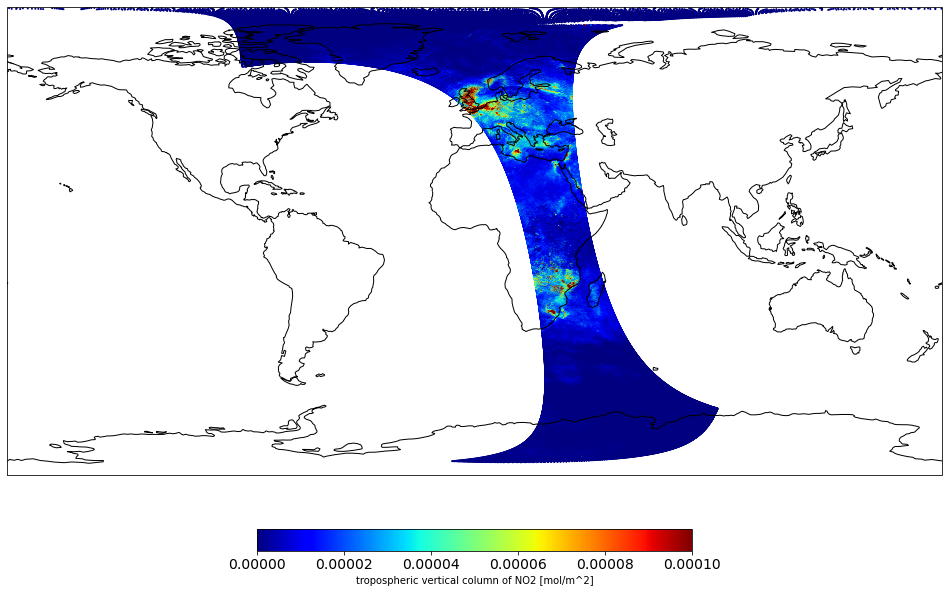

In [8]:
harp_l2geoscatterplot(product, 'tropospheric_NO2_column_number_density', colorrange=(0,0.0001))

/opt/anaconda3/envs/atmoslab/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


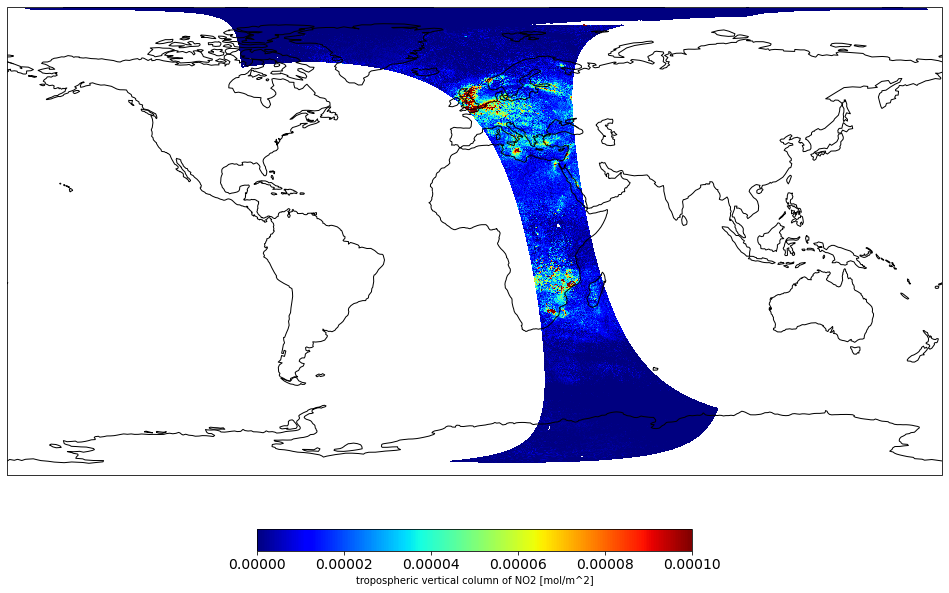

In [9]:
harp_l2geomeshplot(product, 'tropospheric_NO2_column_number_density', colorrange=(0,0.0001))

The scatter plot shows all satellite measurements as individual dots on the map.
Whereas the mesh plot shows data as 2D grid.

**EXERCISE**: Try to plot some other variables from the product using the `harp_l2geomeshplot` or `harp_l2geoscatterplot` functions. Just change the line below and provide a different variable name from the list that was shown by `print(product)`.

/opt/anaconda3/envs/atmoslab/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1598: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  shading=shading)


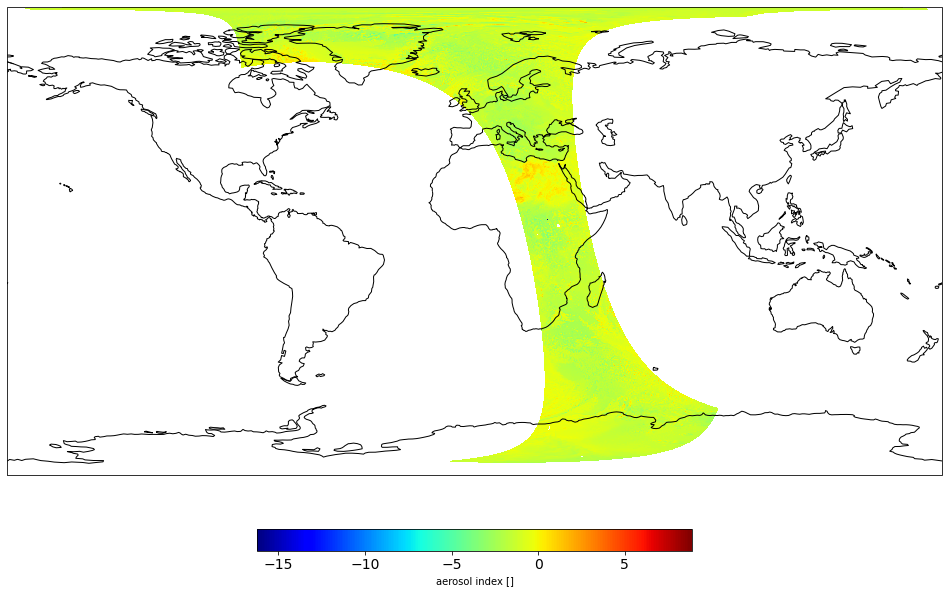

In [10]:
harp_l2geomeshplot(product, 'absorbing_aerosol_index')

When comparing the scatter plot and the mesh plot, the mesh plot looks to be better. However, the mesh plot only works because we ingested all pixels of the product; we still had a full 2D grid that we could plot.
Once we start adding filters this doesn't work anymore.

One of the main features of HARP is the ability to perform operations as part of the data import.
Below we will add three different operations as part of the import:
- we only ingest data that is between 50 and 55 degrees latitude
- we only ingest data where the validity is good enough (this is the `qa_value>0.5` filter that is mentioned in the [Product Readme File for NO2](https://sentinels.copernicus.eu/documents/247904/3541451/Sentinel-5P-Nitrogen-Dioxide-Level-2-Product-Readme-File); the PRFs for all S5P products can be found on the offical [S5P documentation page](https://sentinels.copernicus.eu/web/sentinel/technical-guides/sentinel-5p/products-algorithms))
- we limit the variables that we read to those that we want
- we convert the unit of the tropospheric NO2 column number density to Pmolec/cm2 (instead of using mol/m2 in which that data was stored)

All these operations will be performed by HARP, in sequence, while the data is being read, and before it is returned to us in Python. Since the operations are performed by HARP, which is written in C, it is often much faster to let those operations be performed by HARP than trying to post-process the data yourself in Python.

Information on all operations that can be passed this way can be found in the [HARP operations documentation](http://stcorp.github.io/harp/doc/html/operations.html).

In [11]:
filename = "../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc"
operations = ";".join([
    "latitude>50;latitude<55",
    "tropospheric_NO2_column_number_density_validity>50",
    "keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density)",
    "derive(tropospheric_NO2_column_number_density [Pmolec/cm2])",
])
print(f"operations=\"{operations}\"")
reduced_product = harp.import_product(filename, operations)

operations="latitude>50;latitude<55;tropospheric_NO2_column_number_density_validity>50;keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density);derive(tropospheric_NO2_column_number_density [Pmolec/cm2])"


You will see that importing the data now goes a _lot_ faster. And if we print the contents of the `product` variable we see exactly the data that we requested:

In [12]:
print(reduced_product)

source product = 'S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc'
history = "2020-11-15T21:43:43Z [harp-1.12] harp.import_product('../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc',operations='latitude>50;latitude<55;tropospheric_NO2_column_number_density_validity>50;keep(datetime_start,scan_subindex,latitude,longitude,tropospheric_NO2_column_number_density);derive(tropospheric_NO2_column_number_density [Pmolec/cm2])')"

int scan_subindex {time=46777}
double datetime_start {time=46777} [seconds since 2010-01-01]
float latitude {time=46777} [degree_north]
float longitude {time=46777} [degree_east]
double tropospheric_NO2_column_number_density {time=46777} [Pmolec/cm2]



If we now create a scatter plot we get:

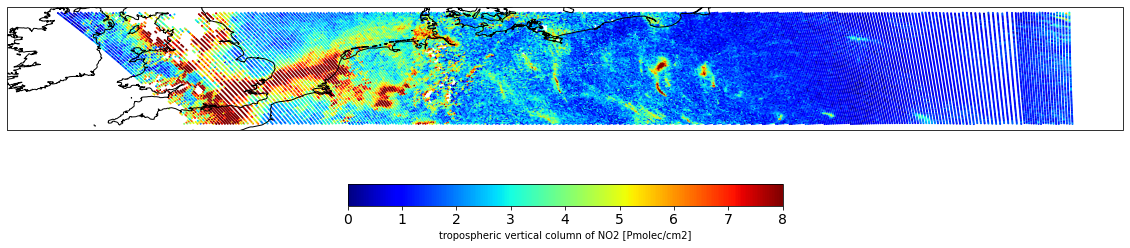

In [13]:
harp_l2geoscatterplot(reduced_product, 'tropospheric_NO2_column_number_density', colorrange=(0,8))

You will now see more clearly that the scatter plot is not really convenient because of the gaps between the dots.

Unfortunately, creating a meshplot doesn't work anymore. If we would try to run:

    harp_l2geomeshplot(reduced_product, 'tropospheric_NO2_column_number_density', colorrange=(0,8))

it will throw an error, because we don't have all pixels for a scanline anymore.

A solution to this problem is to regrid the S5P data to a regular latitude/longitude grid.

Regridding data to a lat/lon grid is also needed of we want to combine the data from multiple orbits from one day into a single daily grid.

We can perform this regridding by using the `bin_spatial()` operation of HARP.
The `bin_spatial()` operation takes 6 parameters:
- the number of latitude _edge_ points
- the latitude offset at which to start the grid
- the latitude increment (= latitude length of a grid cell)
- the number of longitude _edge_ points
- the longitude offset at which to start the grid
- the longitude increment (= longitude length of a grid cell)

Note that the number _edge_ points is one more than the number of grid cells. This is similar to the way you should provide the `X` and `Y` parameters to the `pcolormesh` function (see [matplotlib documentation](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.pcolormesh.html)).

So, if we want to have a 0.1 degree by 0.1 degree global grid, we will need 1800 by 3600 grid cells (which equals 1801 by 3601 grid edge points).

HARP can actually do a proper weighted area average to calculate the value for each grid cell. It will need the corner coordinates of each satellite pixel, provided by the `latitude_bounds` and `longitude_bounds` variables to do this. This is why we need to add these variables to the `keep()` operation we perform below.

In [14]:
filename = "../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc"
operations = ";".join([
    "tropospheric_NO2_column_number_density_validity>75",
    "keep(latitude_bounds,longitude_bounds,tropospheric_NO2_column_number_density)",
    "bin_spatial(1801,-90,0.1,3601,-180,0.1)",
    "derive(tropospheric_NO2_column_number_density [Pmolec/cm2])",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])
grid = harp.import_product(filename, operations)
print(grid)

source product = 'S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc'
history = "2020-11-15T21:43:54Z [harp-1.12] harp.import_product('../eodata/sentinel5p/no2/2020/09/15/S5P_OFFL_L2__NO2____20200915T103056_20200915T121226_15153_01_010302_20200917T040857.nc',operations='tropospheric_NO2_column_number_density_validity>75;keep(latitude_bounds,longitude_bounds,tropospheric_NO2_column_number_density);bin_spatial(1801,-90,0.1,3601,-180,0.1);derive(tropospheric_NO2_column_number_density [Pmolec/cm2]);derive(latitude {latitude});derive(longitude {longitude})')"

double tropospheric_NO2_column_number_density {time=1, latitude=1800, longitude=3600} [Pmolec/cm2]
long count {time=1}
float weight {time=1, latitude=1800, longitude=3600}
double latitude_bounds {latitude=1800, 2} [degree_north]
double longitude_bounds {longitude=3600, 2} [degree_east]
double latitude {latitude=1800} [degree_north]
double longitude {longitude=3600} [degree_east]



To plot this data we define a plot function that can plot variables that depend on the latitude and longitude dimensions:

In [15]:
def harp_l3meshplot(product, value, colorrange=None, colortable='jet'):
    variable = product[value]
    
    gridlat = np.append(product.latitude_bounds.data[:,0], product.latitude_bounds.data[-1,1])
    gridlon = np.append(product.longitude_bounds.data[:,0], product.longitude_bounds.data[-1,1])
    
    if colorrange is not None:
        vmin, vmax = colorrange
    else:
        vmin = np.nanmin(variable.data)
        vmax = np.nanmax(variable.data)

    fig=plt.figure(figsize=(20, 10))

    ax = plt.axes(projection=ccrs.PlateCarree())

    img = plt.pcolormesh(gridlon, gridlat, variable.data[0,:,:], vmin=vmin, vmax=vmax,
                         cmap=colortable, transform=ccrs.PlateCarree())

    ax.coastlines()
    ax.gridlines()

    cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.1)
    cbar.set_label(f'{variable.description} [{variable.unit}]')
    cbar.ax.tick_params(labelsize=14)
    plt.show()


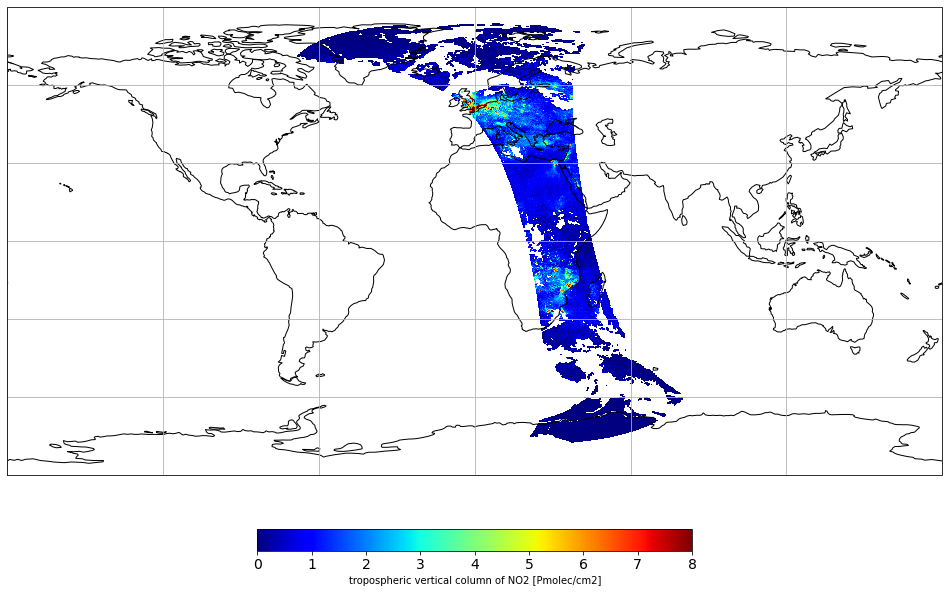

In [16]:
harp_l3meshplot(grid, "tropospheric_NO2_column_number_density", colorrange=(0,8))

We now still plotted only one orbit.
For Sentinel-5P each product file contains the information from one orbit. And there are approximately 14 orbits per day.
With HARP you can just provide the full list of files to the import function, and HARP will then concatenate these products together.
However, to arrive at a daily grid, we then also have to tell HARP to reduce these 14 orbit grids to a single daily grid. This is done by adding the `reduce_operations` parameter to the `harp.import_product()` function.

In [17]:
filenames = "../eodata/sentinel5p/no2/2020/09/15/S5P_*.nc"
operations = ";".join([
    "tropospheric_NO2_column_number_density_validity>75",
    "keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density)",
    "derive(datetime_stop {time} [days since 2000-01-01])",
    "derive(datetime_start [days since 2000-01-01])",
    "exclude(datetime_length)",
    "bin_spatial(1801,-90,0.1,3601,-180,0.1)",
    "derive(tropospheric_NO2_column_number_density [Pmolec/cm2])",
    "derive(latitude {latitude})",
    "derive(longitude {longitude})",
])
reduce_operations = "squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()"
merged = harp.import_product(filenames, operations, reduce_operations=reduce_operations)
print(merged)

history = "2020-11-15T21:45:53Z [harp-1.12] harp.import_product('../eodata/sentinel5p/no2/2020/09/15/S5P_*.nc',operations='tropospheric_NO2_column_number_density_validity>75;keep(latitude_bounds,longitude_bounds,datetime_start,datetime_length,tropospheric_NO2_column_number_density);derive(datetime_stop {time} [days since 2000-01-01]);derive(datetime_start [days since 2000-01-01]);exclude(datetime_length);bin_spatial(1801,-90,0.1,3601,-180,0.1);derive(tropospheric_NO2_column_number_density [Pmolec/cm2]);derive(latitude {latitude});derive(longitude {longitude})',reduce_operations='squash(time, (latitude, longitude, latitude_bounds, longitude_bounds));bin()')"

double datetime_start {time=1} [days since 2000-01-01]
double tropospheric_NO2_column_number_density {time=1, latitude=1800, longitude=3600} [Pmolec/cm2]
double datetime_stop {time=1} [days since 2000-01-01]
long count {time=1}
float weight {time=1, latitude=1800, longitude=3600}
double latitude_bounds {latitude=1800, 2} [degree_no

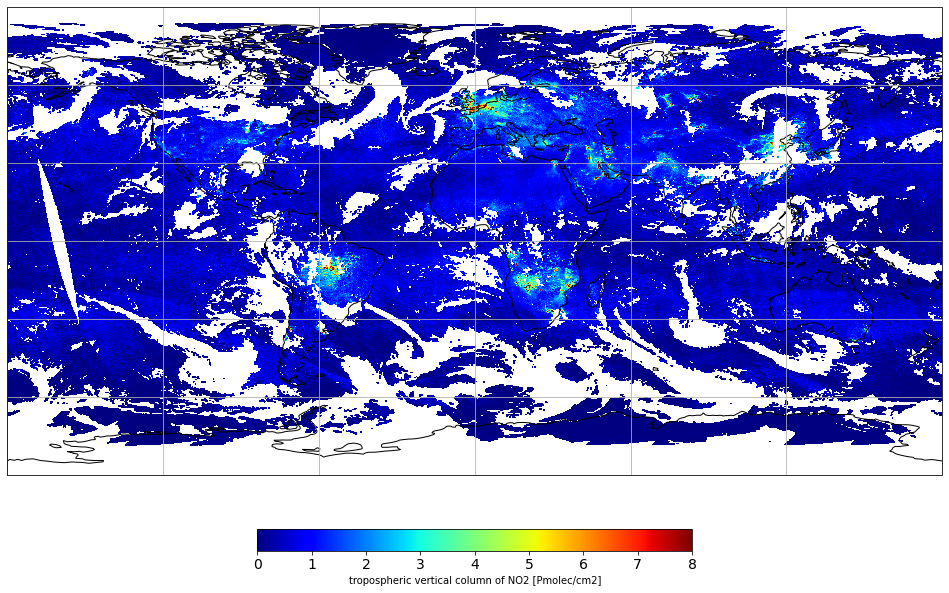

In [18]:
harp_l3meshplot(merged, "tropospheric_NO2_column_number_density", colorrange=(0,8))

**EXCERCISE**: Try to create a daily grid for another variable (e.g. the total NO2 column `NO2_column_number_density`) and/or for a smaller region on the earth (e.g. use `bin_spatial(501,45,0.03,1001,-15,0.03)` for NW Europe).

You can also save the results to a netcdf file and then perform other operations on it.
For instance, we can save the daily grid and then use `gdaldem` to create a geotiff image.
This exact same approach is also what is used to generate the grids on the [Copernicus Sentinel-5P Mapping Portal](https://maps.s5p-pal.com).

In [19]:
harp.export_product(merged, 's5p-no2-20200915.nc', operations="exclude(latitude_bounds, longitude_bounds);derive(tropospheric_NO2_column_number_density [umol/m2])")

In [20]:
# create a color table file (similar to what is used on maps.s5p-pal.com):
with open('colortable.txt', 'a') as f:
   f.write("0 255 245 240 0\n")
   f.write("40 254 224 210 255\n")
   f.write("65 252 187 161 255\n")
   f.write("85 252 146 114 255\n")
   f.write("105 251 106 74 255\n")
   f.write("125 239 59 44 255\n")
   f.write("145 203 24 29 255\n")
   f.write("165 165 15 21 255\n")
   f.write("180 103 0 13 255\n")
   f.write("nv 255 245 240 0\n")

In [21]:
!gdaldem color-relief -q -alpha -of GTiff NETCDF:s5p-no2-20200915.nc:tropospheric_NO2_column_number_density colortable.txt s5p-no2-20200915.tif

Warning 1: Several 1D variables are indexed by dimension time


You can download this tiff file and then open it with e.g. QGIS.
But you can also further process it with GDAL:

In [23]:
# convert the tiff to png and embed it in the notebook below
!gdal_translate s5p-no2-20200915.tif s5p-no2-20200915.png

Input file size is 3600, 1800
0...10...20...30...40...50...60...70...80...90...100 - done.


![s5p-no2-20200915](./s5p-no2-20200915.png)